In [2]:
import cv2
import os
from pathlib import Path
from matplotlib import pyplot as plt
import math
import numpy as np
from tqdm import tqdm

In [3]:
path = Path("Dataset_TP3")
videos_paths = [p for p in path.iterdir() if p.is_file()]

videos = {}
for file in videos_paths:
    vid = cv2.VideoCapture(file)
    if not vid.isOpened():
        print("Error: Could not open video.")
        continue
    videos[file] = vid

In [ ]:
# Histogramme
frame_number = 0
histograms = {}
for vid in videos:
    histograms_frame = []
    video_file = videos[vid]
    print(f"Computing histograms for {vid}")
    frame_count = int(video_file.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_idx in tqdm(range(frame_count)):
        ret, frame = video_file.read()
        if not ret:
            break

        frame_number += 1
        b, g, r = cv2.split(frame)

        hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
        hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])

        hist = []
        hist.append(hist_r)
        hist.append(hist_g)
        hist.append(hist_b)
        histograms_frame.append(hist)
    histograms[vid] = histograms_frame

Computing histograms for Dataset_TP3/combat_cuts.mp4


  0%|          | 0/5047 [00:00<?, ?it/s]

100%|██████████| 5047/5047 [00:05<00:00, 892.61it/s] 


Computing histograms for Dataset_TP3/drone_mouvement_canyon.mp4


100%|██████████| 2015/2015 [00:01<00:00, 1376.78it/s]


Computing histograms for Dataset_TP3/fondu_enchaine_gony.mp4


100%|██████████| 1389/1389 [00:01<00:00, 1118.83it/s]


Computing histograms for Dataset_TP3/tennis_plan_fixe.mp4


100%|██████████| 18278/18278 [00:18<00:00, 997.89it/s] 


In [5]:
def compute_euclidean_distance(hist_a, hist_b) -> float:
    return np.sqrt(np.sum((hist_a - hist_b) ** 2))

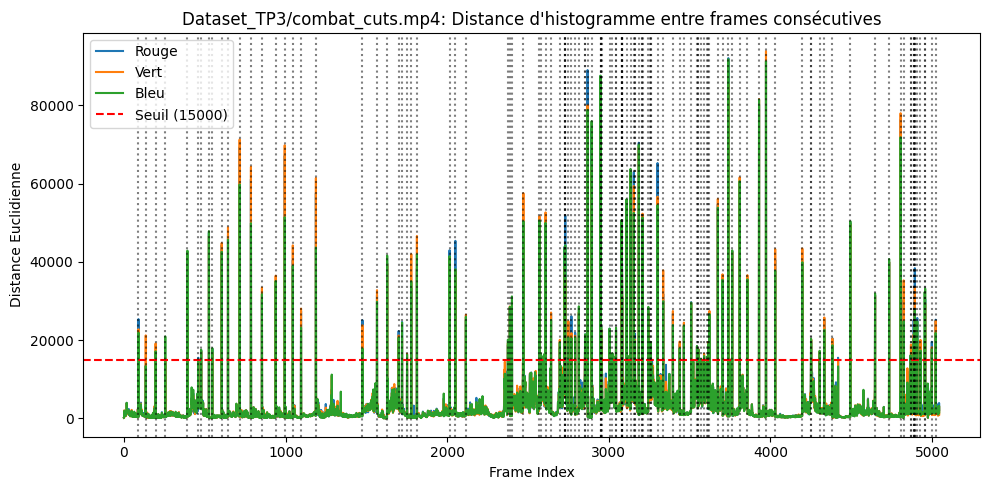

Changements de scène détectés aux frames: [91, 136, 197, 257, 394, 461, 479, 527, 548, 606, 645, 717, 787, 855, 940, 996, 1046, 1097, 1189, 1477, 1567, 1630, 1701, 1722, 1753, 1779, 1814, 2016, 2052, 2117, 2377, 2389, 2402, 2473, 2572, 2581, 2610, 2644, 2698, 2728, 2730, 2731, 2732, 2751, 2770, 2793, 2816, 2854, 2855, 2870, 2895, 2950, 2954, 2955, 2956, 2957, 3006, 3024, 3043, 3046, 3080, 3081, 3082, 3083, 3084, 3085, 3111, 3136, 3156, 3161, 3163, 3187, 3208, 3209, 3210, 3246, 3257, 3260, 3261, 3303, 3338, 3398, 3440, 3466, 3511, 3547, 3555, 3556, 3572, 3591, 3609, 3616, 3624, 3676, 3705, 3741, 3765, 3811, 3859, 3931, 3974, 4031, 4199, 4253, 4254, 4306, 4335, 4385, 4496, 4649, 4736, 4807, 4826, 4869, 4871, 4888, 4890, 4892, 4894, 4895, 4910, 4930, 4956, 4959, 5000, 5024]


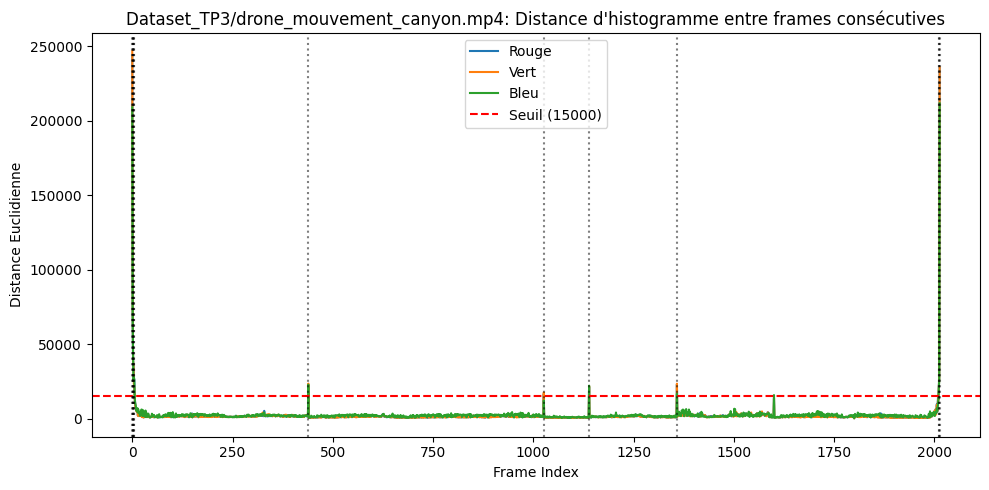

Changements de scène détectés aux frames: [1, 2, 3, 4, 5, 6, 440, 1027, 1140, 1359, 2012, 2013, 2014]


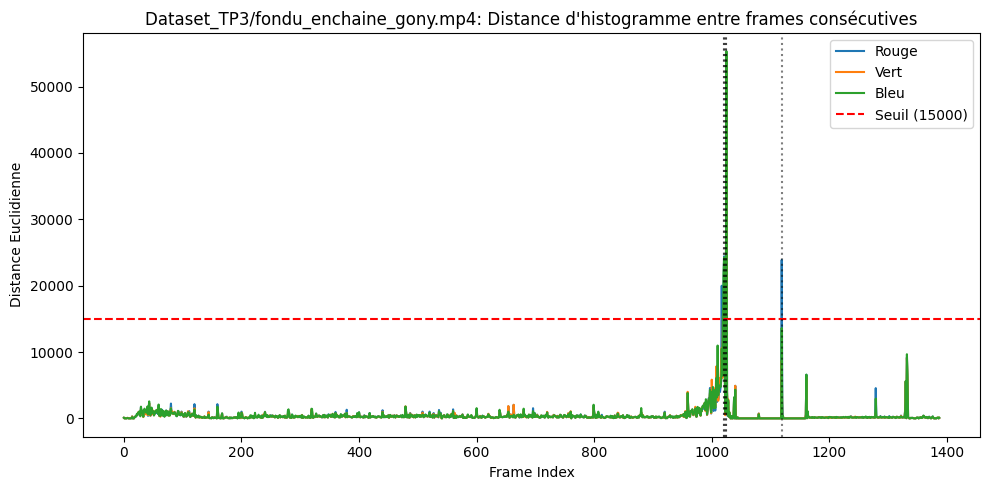

Changements de scène détectés aux frames: [1021, 1022, 1025, 1026, 1120]


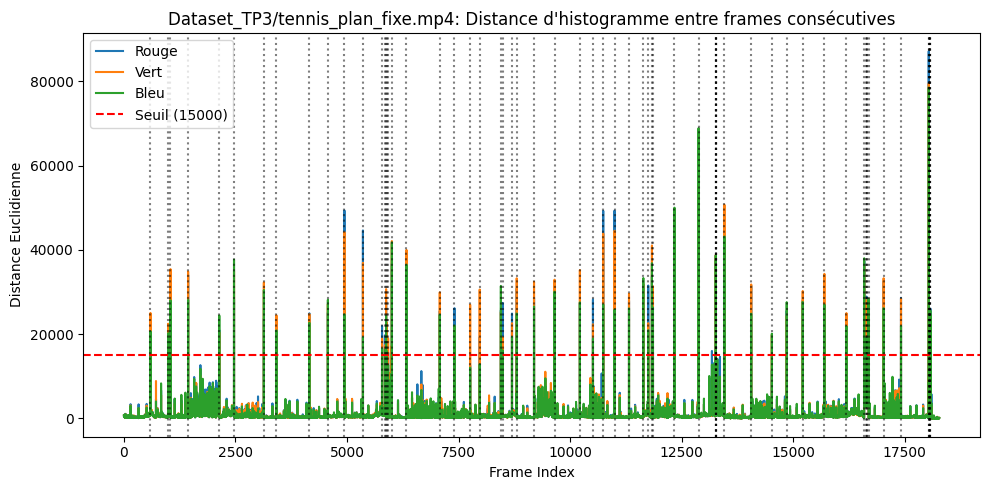

Changements de scène détectés aux frames: [596, 993, 1045, 1440, 2139, 2469, 3138, 3420, 4158, 4573, 4944, 5359, 5787, 5852, 5878, 5891, 5923, 6007, 6335, 7081, 7411, 7762, 7976, 8451, 8490, 8700, 8806, 9194, 9654, 10222, 10515, 10745, 10998, 11323, 11644, 11754, 11837, 11860, 12342, 12882, 13266, 13267, 13268, 13269, 13272, 13462, 14062, 14525, 14858, 15217, 15703, 16197, 16595, 16646, 16648, 16660, 16692, 17031, 17420, 18042, 18055, 18056, 18060, 18069, 18078, 18081]


In [6]:
SEUIL = 45000
N = 2
cuts: dict[Path, list[int]] = {}

for histo in histograms:
    frames = histograms[histo]
    distance_r = []
    distance_g = []
    distance_b = []
    scene_changes = []

    for i in range(1, len(frames)):
        prev_r, prev_g, prev_b = frames[i - 1]
        curr_r, curr_g, curr_b = frames[i]

        dist_r = compute_euclidean_distance(
            prev_r,
            curr_r,
        )
        dist_g = compute_euclidean_distance(
            prev_g,
            curr_g,
        )
        dist_b = compute_euclidean_distance(
            prev_b,
            curr_b,
        )

        distance_r.append(dist_r)
        distance_g.append(dist_g)
        distance_b.append(dist_b)

        total_dist = dist_r + dist_g + dist_b

        if total_dist > SEUIL:
            scene_changes.append(i)

    cuts[histo] = scene_changes

    plt.figure(figsize=(10, 5))
    plt.plot(distance_r, label="Rouge")
    plt.plot(distance_g, label="Vert")
    plt.plot(distance_b, label="Bleu")
    plt.axhline(
        y=SEUIL / 3, color="r", linestyle="--", label=f"Seuil ({SEUIL / 3:.0f})"
    )

    for sc in scene_changes:
        plt.axvline(x=sc - 1, color="k", linestyle=":", alpha=0.5)

    plt.xlabel("Frame Index")
    plt.ylabel("Distance Euclidienne")
    plt.title(f"{histo}: Distance d'histogramme entre frames consécutives")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Changements de scène détectés aux frames: {scene_changes}")

In [ ]:
DETECTION_THRESHOLD = 1
from pathlib import Path

cuts_path = Path("./cuts")

for cut_name in cuts:
    name_file = cut_name.name.split(".")[0]
    valid_cuts_path = cuts_path / f"{name_file}.txt"

    if not valid_cuts_path.exists():
        print(f"Ground truth file not found: {valid_cuts_path}")
        continue

    valid_cuts_str = open(valid_cuts_path, "r").read()

    valid_cuts = []
    for x in valid_cuts_str.split(","):
        stripped = x.strip()
        if stripped.isdigit():
            valid_cuts.append(int(stripped))

    gen_cuts = cuts[cut_name]

    correct_cuts = []
    incorrect_cuts = []

    for gc in gen_cuts:
        found = False
        for vc in valid_cuts:
            if abs(gc - vc) <= DETECTION_THRESHOLD:
                found = True
                break
        if found:
            correct_cuts.append(gc)
        else:
            incorrect_cuts.append(gc)

    # Calculate percentages
    total_detected = len(gen_cuts)
    if total_detected > 0:
        pct_correct = len(correct_cuts) / total_detected * 100
        pct_incorrect = len(incorrect_cuts) / total_detected * 100
    else:
        pct_correct = 0.0
        pct_incorrect = 0.0

    if valid_cuts:
        missed_cuts = []
        for vc in valid_cuts:
            detected = any(abs(gc - vc) <= DETECTION_THRESHOLD for gc in gen_cuts)
            if not detected:
                missed_cuts.append(vc)
        recall = (len(valid_cuts) - len(missed_cuts)) / len(valid_cuts) * 100
    else:
        missed_cuts = []
        recall = 0.0

    print(f"\n{'=' * 50}")
    print(f"Vidéo: {cut_name.name}")
    print(f"{'=' * 50}")
    print(f"Cuts détectés: {total_detected} | Ground truth: {len(valid_cuts)}")
    print(f"\n✓ Détections correctes: {len(correct_cuts)} ({pct_correct:.1f}%)")
    print(f"  Frames: {correct_cuts}")
    print(f"\n✗ Faux positifs: {len(incorrect_cuts)} ({pct_incorrect:.1f}%)")
    print(f"  Frames: {incorrect_cuts}")
    print(f"\n⊘ Cuts manqués: {len(missed_cuts)} ({100 - recall:.1f}% du ground truth)")
    print(f"  Frames: {missed_cuts}")
    print(f"\nRappel: {recall:.1f}%")


Vidéo: combat_cuts.mp4
Cuts détectés: 126 | Ground truth: 77

✓ Détections correctes: 76 (60.3%)
  Frames: [136, 197, 257, 394, 527, 548, 606, 645, 717, 787, 855, 940, 996, 1046, 1097, 1189, 1477, 1567, 1630, 1701, 1722, 1753, 1779, 1814, 2016, 2052, 2117, 2377, 2389, 2402, 2473, 2572, 2610, 2644, 2698, 2728, 2751, 2770, 2793, 2816, 2870, 2895, 2950, 3006, 3046, 3080, 3111, 3136, 3156, 3187, 3208, 3209, 3210, 3246, 3303, 3338, 3398, 3440, 3466, 3511, 3624, 3676, 3705, 3741, 3765, 3811, 3859, 3931, 3974, 4031, 4199, 4335, 4385, 4496, 4649, 4736]

✗ Faux positifs: 50 (39.7%)
  Frames: [91, 461, 479, 2581, 2730, 2731, 2732, 2854, 2855, 2954, 2955, 2956, 2957, 3024, 3043, 3081, 3082, 3083, 3084, 3085, 3161, 3163, 3257, 3260, 3261, 3547, 3555, 3556, 3572, 3591, 3609, 3616, 4253, 4254, 4306, 4807, 4826, 4869, 4871, 4888, 4890, 4892, 4894, 4895, 4910, 4930, 4956, 4959, 5000, 5024]

⊘ Cuts manqués: 3 (3.9% du ground truth)
  Frames: [2982, 4251, 4419]

Rappel: 96.1%

Vidéo: drone_mouvement_ca